<a href="https://colab.research.google.com/github/DmitryProffessor/Multibank_service/blob/main/keras_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import random

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Определение среды (окружения)

In [10]:
class SavingsEnv:
    def __init__(self, max_steps=12):
        self.max_steps = max_steps
        self.action_space = 3  # 0: 0%, 1: 10%, 2: 20%
        self.observation_space = 3  # [income, expenses, balance]
        self.reset()

    def reset(self):
        income = np.random.uniform(30_000, 70_000)
        expenses = np.random.uniform(20_000, min(60_000, income))
        balance = np.random.uniform(10_000, 100_000)
        self.state = np.array([income, expenses, balance], dtype=np.float32)
        self.step_count = 0
        return self.state.copy()

    def step(self, action):
        income, expenses, balance = self.state
        savings_rate = [0.0, 0.1, 0.2][action]
        savings = income * savings_rate
        new_balance = balance + income - expenses - savings

        # Награда
        reward = new_balance / 10_000
        if new_balance < 10_000:
            reward -= 5.0

        self.step_count += 1
        done = (self.step_count >= self.max_steps)

        # Реалистичные колебания
        income = np.clip(income * np.random.uniform(0.95, 1.05), 20_000, 100_000)
        expenses = np.clip(expenses * np.random.uniform(0.9, 1.1), 10_000, income * 0.9)
        self.state = np.array([income, expenses, new_balance], dtype=np.float32)

        return self.state.copy(), reward, done

Создание DQN-модели

In [11]:
def build_dqn_model(state_size, action_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(state_size,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(action_size, activation='linear')  # Q-values
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

state_size = 3
action_size = 3
main_model = build_dqn_model(state_size, action_size)
target_model = build_dqn_model(state_size, action_size)
target_model.set_weights(main_model.get_weights())  # синхронизируем веса

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  **kwargs,


Replay Buffer и параметры обучения

In [12]:
# Гиперпараметры
gamma = 0.99          # discount factor
epsilon = 1.0         # начальная ε
epsilon_min = 0.01    # минимальная ε
epsilon_decay = 0.995
batch_size = 64
memory = deque(maxlen=10000)
episodes = 500
target_update_freq = 50  # обновлять target каждые 50 эпизодов

# Вспомогательная функция выбора действия
def choose_action(state, epsilon):
    if np.random.random() <= epsilon:
        return random.randint(0, action_size - 1)
    q_values = main_model.predict(state[np.newaxis], verbose=0)
    return np.argmax(q_values[0])

Обучение агента

In [13]:
env = SavingsEnv()
rewards_history = []
losses_history = []

print("Начинаем обучение...")

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    episode_losses = []

    while True:
        action = choose_action(state, epsilon)
        next_state, reward, done = env.step(action)
        memory.append((state, action, reward, next_state, done))
        total_reward += reward

        # Обучение из буфера
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states = np.array([e[0] for e in batch])
            actions = np.array([e[1] for e in batch])
            rewards = np.array([e[2] for e in batch])
            next_states = np.array([e[3] for e in batch])
            dones = np.array([e[4] for e in batch])

            # Текущие Q-значения
            current_q = main_model.predict(states, verbose=0)
            # Целевые Q-значения
            next_q = target_model.predict(next_states, verbose=0)
            targets = rewards + gamma * np.max(next_q, axis=1) * (1 - dones)
            current_q[np.arange(batch_size), actions] = targets

            # Обучение
            history = main_model.fit(states, current_q, epochs=1, verbose=0)
            episode_losses.append(history.history['loss'][0])

        state = next_state
        if done:
            break

    # Обновление ε
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Обновление target-модели
    if episode % target_update_freq == 0:
        target_model.set_weights(main_model.get_weights())

    rewards_history.append(total_reward)
    if episode_losses:
        losses_history.append(np.mean(episode_losses))

    if episode % 100 == 0:
        print(f"Эпизод {episode}, Средняя награда: {np.mean(rewards_history[-100:]):.2f}, ε: {epsilon:.3f}")

print("Обучение завершено!")

Начинаем обучение...
Эпизод 0, Средняя награда: 77.56, ε: 0.995
Эпизод 100, Средняя награда: 167.64, ε: 0.603
Эпизод 200, Средняя награда: 158.76, ε: 0.365
Эпизод 300, Средняя награда: 136.75, ε: 0.221
Эпизод 400, Средняя награда: 155.76, ε: 0.134
Обучение завершено!


Графики и оценка

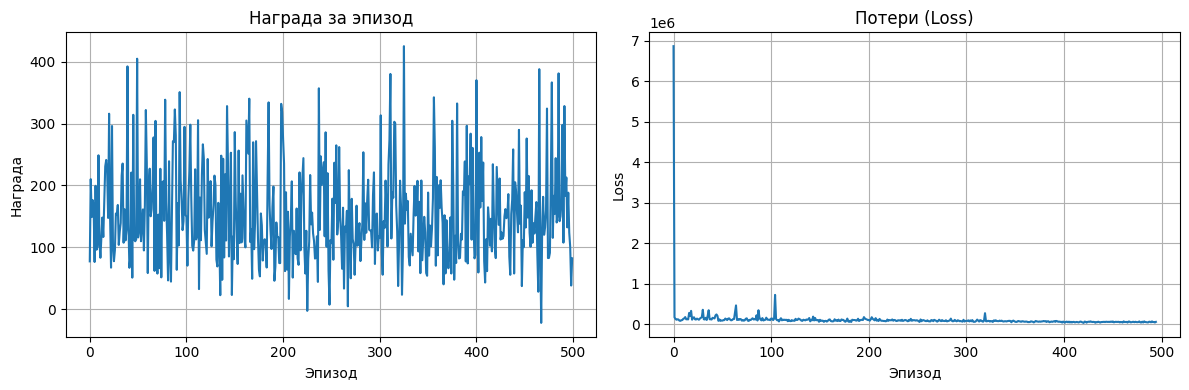

In [14]:
# График наград
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title("Награда за эпизод")
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(losses_history)
plt.title("Потери (Loss)")
plt.xlabel("Эпизод")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

Тестирование обученной политики

Случайная стратегия:   средняя награда = 147.66
Обученный агент:       средняя награда = 150.10


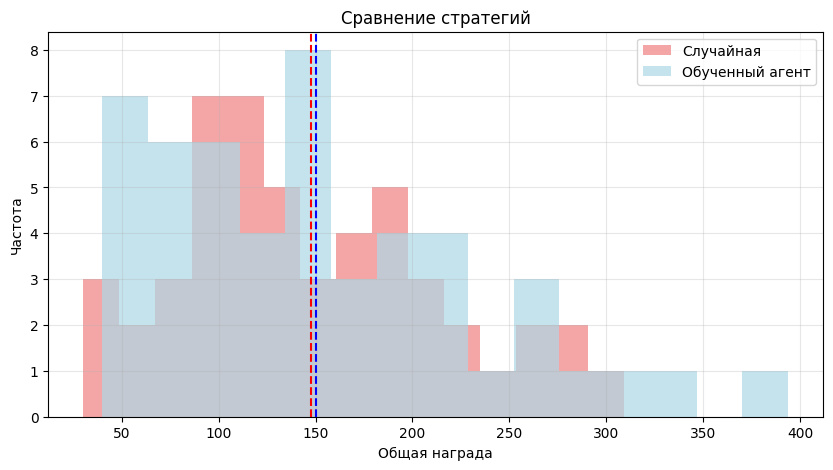

In [15]:
def test_policy(env, model, episodes=50):
    rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        while True:
            q_values = model.predict(state[np.newaxis], verbose=0)
            action = np.argmax(q_values[0])
            state, reward, done = env.step(action)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards

# Случайная политика
def test_random_policy(env, episodes=50):
    rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        while True:
            action = random.randint(0, 2)
            state, reward, done = env.step(action)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards

# Тестируем
trained_rewards = test_policy(env, main_model)
random_rewards = test_random_policy(env)

print(f"Случайная стратегия:   средняя награда = {np.mean(random_rewards):.2f}")
print(f"Обученный агент:       средняя награда = {np.mean(trained_rewards):.2f}")

# График сравнения
plt.figure(figsize=(10, 5))
plt.hist(random_rewards, bins=15, alpha=0.7, label='Случайная', color='lightcoral')
plt.hist(trained_rewards, bins=15, alpha=0.7, label='Обученный агент', color='lightblue')
plt.axvline(np.mean(random_rewards), color='red', linestyle='--')
plt.axvline(np.mean(trained_rewards), color='blue', linestyle='--')
plt.title("Сравнение стратегий")
plt.xlabel("Общая награда")
plt.ylabel("Частота")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Интерактивный режим тестирования

In [16]:
def interactive_test():
    env = SavingsEnv()
    state = env.reset()
    total_reward = 0
    step_count = 0

    print("=== ИНТЕРАКТИВНЫЙ РЕЖИМ УПРАВЛЕНИЯ СБЕРЕЖЕНИЯМИ ===")
    print("Доступные действия:")
    print("0 - Не откладывать (0%)")
    print("1 - Отложить 10%")
    print("2 - Отложить 20%")
    print("q - Выйти\n")

    while True:
        income, expenses, balance = state
        print(f"Месяц {step_count + 1}:")
        print(f"Доход: {income:.2f} руб.")
        print(f"Расходы: {expenses:.2f} руб.")
        print(f"Баланс: {balance:.2f} руб.")

        # Получаем рекомендацию от ИИ
        q_values = main_model.predict(state[np.newaxis], verbose=0)
        ai_action = np.argmax(q_values[0])
        ai_rates = ["0%", "10%", "20%"]
        print(f"Рекомендация ИИ: отложить {ai_rates[ai_action]}")

        # Пользовательский ввод
        user_input = input("Ваше действие (0-2 или 'q' для выхода): ").strip().lower()

        if user_input == 'q':
            break

        try:
            action = int(user_input)
            if action not in [0, 1, 2]:
                print("Ошибка: введите 0, 1 или 2")
                continue
        except ValueError:
            print("Ошибка: введите число от 0 до 2")
            continue

        # Выполняем действие
        state, reward, done = env.step(action)
        total_reward += reward

        print(f"Награда за шаг: {reward:.2f}")
        print(f"Общая награда: {total_reward:.2f}")
        print("-" * 40)

        step_count += 1
        if done:
            print("Эпизод завершен! Максимальное количество шагов достигнуто.")
            break

    print(f"Итоговая награда: {total_reward:.2f}")

# Запускаем интерактивный режим после обучения
interactive_test()

=== ИНТЕРАКТИВНЫЙ РЕЖИМ УПРАВЛЕНИЯ СБЕРЕЖЕНИЯМИ ===
Доступные действия:
0 - Не откладывать (0%)
1 - Отложить 10%
2 - Отложить 20%
q - Выйти

Месяц 1:
Доход: 60114.07 руб.
Расходы: 58763.74 руб.
Баланс: 74716.07 руб.
Рекомендация ИИ: отложить 10%
Ваше действие (0-2 или 'q' для выхода): 1
Награда за шаг: 7.01
Общая награда: 7.01
----------------------------------------
Месяц 2:
Доход: 57813.41 руб.
Расходы: 52032.06 руб.
Баланс: 70055.00 руб.
Рекомендация ИИ: отложить 10%
Ваше действие (0-2 или 'q' для выхода): 2
Награда за шаг: 6.43
Общая награда: 13.43
----------------------------------------
Месяц 3:
Доход: 56578.90 руб.
Расходы: 50921.01 руб.
Баланс: 64273.66 руб.
Рекомендация ИИ: отложить 10%
Ваше действие (0-2 или 'q' для выхода): 3
Ошибка: введите 0, 1 или 2
Месяц 3:
Доход: 56578.90 руб.
Расходы: 50921.01 руб.
Баланс: 64273.66 руб.
Рекомендация ИИ: отложить 10%
Ваше действие (0-2 или 'q' для выхода): 4
Ошибка: введите 0, 1 или 2
Месяц 3:
Доход: 56578.90 руб.
Расходы: 50921.01 руб.

Симулятор финансового планирования

=== ФИНАНСОВЫЙ СИМУЛЯТОР ===
Введите ваш доход (или Enter для случайного): 
Введите ваши расходы (или Enter для случайного): 
Введите начальный баланс (или Enter для случайного): 

--- Месяц 1 ---
Доход: 54464.39 руб.
Расходы: 20066.01 руб.
Текущий баланс: 60842.46 руб.
🤖 Рекомендация: отложить 0% (0.00 руб.)

--- Месяц 2 ---
Доход: 53194.82 руб.
Расходы: 19172.25 руб.
Текущий баланс: 95240.83 руб.
🤖 Рекомендация: отложить 10% (5319.48 руб.)

--- Месяц 3 ---
Доход: 51276.31 руб.
Расходы: 17385.67 руб.
Текущий баланс: 123943.91 руб.
🤖 Рекомендация: отложить 10% (5127.63 руб.)

--- Месяц 4 ---
Доход: 52460.02 руб.
Расходы: 18733.93 руб.
Текущий баланс: 152706.92 руб.
🤖 Рекомендация: отложить 10% (5246.00 руб.)

--- Месяц 5 ---
Доход: 50447.77 руб.
Расходы: 19943.92 руб.
Текущий баланс: 181187.02 руб.
🤖 Рекомендация: отложить 20% (10089.55 руб.)

--- Месяц 6 ---
Доход: 52178.05 руб.
Расходы: 21280.28 руб.
Текущий баланс: 201601.31 руб.
🤖 Рекомендация: отложить 20% (10435.61 руб.)

--- Мес

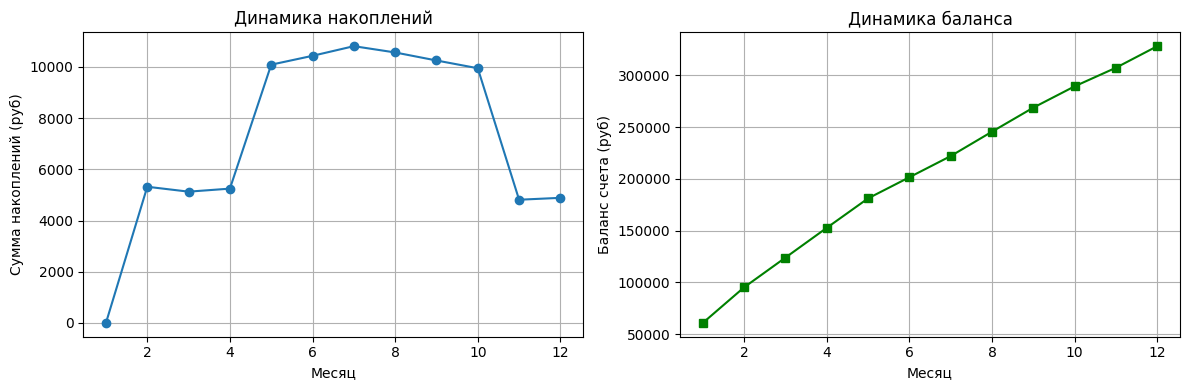

In [17]:
def financial_simulator():
    print("=== ФИНАНСОВЫЙ СИМУЛЯТОР ===")

    # Пользовательские настройки
    try:
        custom_income = float(input("Введите ваш доход (или Enter для случайного): ") or 0)
        custom_expenses = float(input("Введите ваши расходы (или Enter для случайного): ") or 0)
        custom_balance = float(input("Введите начальный баланс (или Enter для случайного): ") or 0)
    except ValueError:
        print("Используются случайные значения...")
        custom_income = custom_expenses = custom_balance = 0

    env = SavingsEnv()
    state = env.reset()

    # Применяем пользовательские значения, если они заданы
    if custom_income > 0:
        state[0] = custom_income
    if custom_expenses > 0:
        state[1] = custom_expenses
    if custom_balance > 0:
        state[2] = custom_balance

    months = 12
    savings_history = []
    balance_history = []

    for month in range(months):
        income, expenses, balance = state
        print(f"\n--- Месяц {month + 1} ---")
        print(f"Доход: {income:.2f} руб.")
        print(f"Расходы: {expenses:.2f} руб.")
        print(f"Текущий баланс: {balance:.2f} руб.")

        # Рекомендация ИИ
        q_values = main_model.predict(state[np.newaxis], verbose=0)
        ai_action = np.argmax(q_values[0])
        recommended_rate = ["0%", "10%", "20%"][ai_action]
        savings_amount = income * [0, 0.1, 0.2][ai_action]

        print(f"🤖 Рекомендация: отложить {recommended_rate} ({savings_amount:.2f} руб.)")

        # Сохраняем историю
        savings_history.append(savings_amount)
        balance_history.append(balance)

        # Автоматически применяем рекомендацию ИИ
        state, reward, done = env.step(ai_action)

        if done:
            break

    # Итоговый отчет
    print("\n" + "="*50)
    print("ИТОГОВЫЙ ФИНАНСОВЫЙ ОТЧЕТ")
    print("="*50)
    print(f"Общая сумма накоплений: {sum(savings_history):.2f} руб.")
    print(f"Финальный баланс: {state[2]:.2f} руб.")
    print(f"Среднемесячные накопления: {np.mean(savings_history):.2f} руб.")

    # График прогресса
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(savings_history) + 1), savings_history, 'o-', label='Накопления')
    plt.xlabel('Месяц')
    plt.ylabel('Сумма накоплений (руб)')
    plt.title('Динамика накоплений')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(balance_history) + 1), balance_history, 's-', color='green', label='Баланс')
    plt.xlabel('Месяц')
    plt.ylabel('Баланс счета (руб)')
    plt.title('Динамика баланса')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Запускаем симулятор
financial_simulator()